In [1]:
#Импортируем библиотеки, которые понадобятся в процессе анализа
import pandas as pd
import numpy as np
import seaborn as sns
import requests
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from operator import attrgetter

Подключаюсь к файлам из яндекс диска с помощью API

In [2]:
#Формируем ссылки на данные с яндекс диска
customers_link = 'https://disk.yandex.ru/d/YYRsaU1Fy5RiSQ'
orders_link = 'https://disk.yandex.ru/d/wHpsXAoAbjh47A'
order_items_link = 'https://disk.yandex.ru/d/0nhiZwlHU1Rumg'
    

In [3]:
 def get_file_content(public_link, parse_dates=None):
    """
        Возвращает датафрейм полученный по ссылке с Яндекс диска. 
        На вход принимает публичную ссылку. 
    """
    api_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download"
    params = {"public_key": public_link}

    response = requests.get(api_url, params=params)
    if response.status_code == 200:
        download_url = response.json()["href"]

        df = pd.read_csv(download_url,parse_dates=parse_dates)
        return df
    else:
        print("Ошибка при получении ссылки:", response.json())

In [4]:
#Загружаем данные для анализа
#1.Таблица с уникальными идентификаторами пользователей
olist_customers_dataset = get_file_content(customers_link)
#2.Таблица заказов. Делаем преобразование колонок с временем в нужный формат
olist_orders_dataset = get_file_content(orders_link,parse_dates= ['order_purchase_timestamp', 
                                                  'order_approved_at', 
                                                  'order_delivered_carrier_date', 
                                                  'order_delivered_customer_date', 
                                                  'order_estimated_delivery_date'])
#3.Товарные позиции, входящие в заказы
olist_order_items_dataset = get_file_content(order_items_link, parse_dates =['shipping_limit_date'])

# Проводим EDA - предварительный анализ данных


**Cмотрим данные Таблицы.1 (с уникальными идентификаторами пользователей)**\
customer_id — позаказный идентификатор пользователя

customer_unique_id — уникальный идентификатор пользователя (аналог номера паспорта)

customer_zip_code_prefix — почтовый индекс пользователя

customer_city — город доставки пользователя

customer_state — штат доставки пользователя

In [5]:
#Посмотрим, как отображаются данные
olist_customers_dataset.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
#Смотрим объем изначальных данных
olist_customers_dataset.shape

(99441, 5)

In [7]:
#Проверяем тип данных
olist_customers_dataset.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [8]:
#Проверяем на наличие пропущенных значений
olist_customers_dataset.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

**Cмотрим данные Таблицы.2 (Заказов)**\
order_id — уникальный идентификатор заказа (номер чека)

customer_id — позаказный идентификатор пользователя

order_status — статус заказа

order_purchase_timestamp — время создания заказа

order_approved_at — время подтверждения оплаты заказа

order_delivered_carrier_date — время передачи заказа в логистическую службу

order_delivered_customer_date — время доставки заказа

order_estimated_delivery_date — обещанная дата доставки

In [9]:
#Посмотрим, как отображаются данные
olist_orders_dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [10]:
#Смотрим объем данных в таблице заказов
olist_orders_dataset.shape

(99441, 8)

In [11]:
#Проверим тип данных
olist_orders_dataset.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [12]:
#Проверяем на наличие пропущенных значений
olist_orders_dataset.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [13]:
#Проверим какие статус есть по заказам
olist_orders_dataset.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

Статусы заказов\
**created** — создан\
**approved** — подтверждён\
**invoiced** — выставлен счёт\
**processing** — в процессе сборки заказа\
**shipped** — отгружён со склада\
**delivered** — доставлен пользователю\
**unavailable** — заказ отменён по причине недоступности товара\
**canceled** — отменён.

**Cмотрим данные Таблицы.3 (Товарных позиций, входящих в заказы)**\
order_id — уникальный идентификатор заказа (номер чека)

order_item_id — идентификатор товара внутри одного заказа

product_id — ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date — максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price — цена за единицу товара

freight_value — вес товара 

In [14]:
#Посмотрим, как отображаются данные
olist_order_items_dataset.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [15]:
#Проверим тип данных
olist_order_items_dataset.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [16]:
#Проверяем на наличие пропущенных значений
olist_order_items_dataset.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

#  Оцениваем месячный retention в оформление заказа с помощью когортного анализа.

In [17]:
#Объединяем нужные таблицы с данными о заказах и пользователях
customers_orders = olist_customers_dataset.merge(olist_orders_dataset, on = 'customer_id')
customers_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [18]:
# Создаем копию данных, чтобы избежать изменений в исходном DataFrame и отбираем нужные для расчета retention заказы - delivered
customers_orders_сopy = customers_orders[customers_orders['order_status']=='delivered'].copy()

In [19]:
#проверяю изменние количества данных
customers_orders_сopy.shape 

(96478, 12)

In [20]:
 #проверяю статус заказа в отфильтрованных данных
customers_orders_сopy.order_status.unique() #

array(['delivered'], dtype=object)

In [21]:
# Извлекаем месяц и день заказа
customers_orders_сopy['order_period'] = customers_orders_сopy['order_purchase_timestamp'].dt.to_period('M')
customers_orders_сopy['order_period_day'] = customers_orders_сopy['order_purchase_timestamp'].dt.to_period('D')

In [22]:
# Присваиваем когорты на основе даты первого действия для каждого пользователя
customers_orders_сopy['cohort'] = customers_orders_сopy.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
customers_orders_сopy['cohort_day'] = customers_orders_сopy.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('D')

In [23]:
# Рассчитываем номер периода в днях (месячные периоды, деля на 30)
customers_orders_сopy['period_number_month'] = np.floor((customers_orders_сopy.order_period_day - customers_orders_сopy.cohort_day).apply(attrgetter('n')) / 30)

In [24]:
customers_orders_сopy.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_period,order_period_day,cohort,cohort_day,period_number_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,2017-05-16,2017-05,2017-05-16,0.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01,2018-01-12,2018-01,2018-01-12,0.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05,2018-05-19,2018-05,2018-05-19,0.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03,2018-03-13,2018-03,2018-03-13,0.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07,2018-07-29,2018-07,2018-07-29,0.0


In [25]:
# Агрегируем данные по когортам и рассчитанному номеру периода (в месяцах)
df_cohort = customers_orders_сopy.groupby(['cohort', 'period_number_month']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index()

In [26]:
df_cohort

,cohort,period_number_month,n_customers
0,2016-09,0.0,1
1,2016-10,0.0,262
2,2016-10,6.0,1
3,2016-10,9.0,1
4,2016-10,11.0,1
...,...,...,...
210,2018-06,1.0,22
211,2018-06,2.0,6
212,2018-07,0.0,5949
213,2018-07,1.0,6


In [27]:
# Создаем сводную таблицу для когортного анализа
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number_month', values='n_customers')

In [28]:
cohort_pivot.head()

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,262.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,1.0,1.0
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,717.0,2.0,NaN,4.0,1.0,1.0,2.0,2.0,NaN,NaN,...,4.0,3.0,2.0,NaN,2.0,2.0,2.0,1.0,NaN,NaN
2017-02,1628.0,2.0,3.0,6.0,4.0,2.0,4.0,1.0,2.0,4.0,...,6.0,1.0,3.0,2.0,1.0,1.0,3.0,NaN,NaN,NaN


In [29]:
# Рассчитываем размеры когорт (первый столбец сводной таблицы)
cohort_size = cohort_pivot.iloc[:, 0]

In [30]:
# Вычисляем коэффициенты удержания, деля на размер когорты
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

In [31]:
retention_matrix.head()

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,...,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.003817,0.003817
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002789,NaN,0.005579,0.001395,0.001395,0.002789,0.002789,NaN,NaN,...,0.005579,0.004184,0.002789,NaN,0.002789,0.002789,0.002789,0.001395,NaN,NaN
2017-02,1.0,0.001229,0.001843,0.003686,0.002457,0.001229,0.002457,0.000614,0.001229,0.002457,...,0.003686,0.000614,0.001843,0.001229,0.000614,0.000614,0.001843,NaN,NaN,NaN


In [32]:
#Убираю колонку нулевого месяца, чтобы визуализация retention была показательной
retention_matrix = retention_matrix.drop(columns=0, errors='ignore')

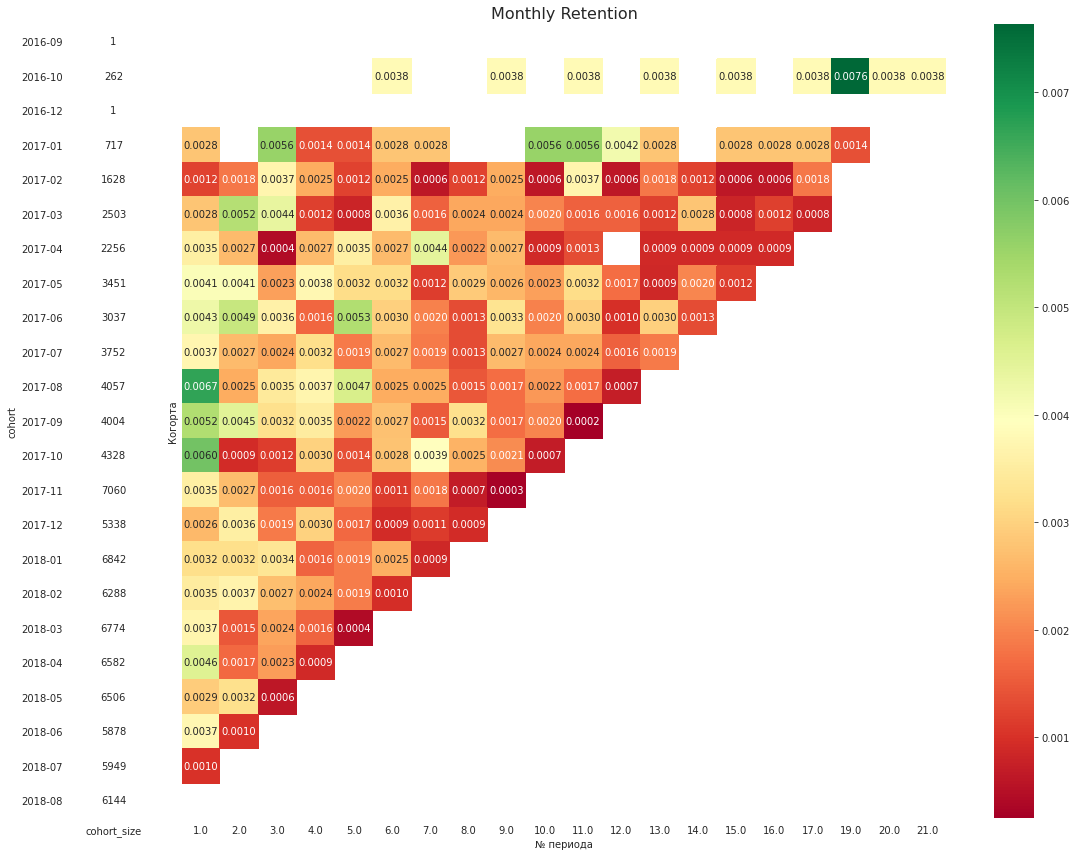

In [33]:
# Строим тепловую карту когортного анализа
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.4f', 
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()

In [34]:
#Посмотрим на описательную статистику
retention_matrix.describe()

period_number_month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
count,19.000000,17.000000,17.000000,16.000000,15.000000,15.000000,13.000000,11.000000,11.000000,10.000000,10.000000,7.000000,8.000000,5.000000,6.000000,4.000000,4.000000,2.000000,1.000000,1.000000
mean,0.003639,0.002927,0.002650,0.002350,0.002235,0.002509,0.002013,0.001846,0.002339,0.002068,0.002653,0.001637,0.002029,0.001651,0.001678,0.001372,0.002312,0.004514,0.003817,0.003817
std,0.001388,0.001298,0.001337,0.000942,0.001369,0.000870,0.001140,0.000847,0.000917,0.001412,0.001525,0.001209,0.001072,0.000763,0.001312,0.000975,0.001291,0.004412,NaN,NaN
min,0.001009,0.000924,0.000443,0.000912,0.000443,0.000937,0.000614,0.000708,0.000283,0.000614,0.000250,0.000614,0.000869,0.000887,0.000614,0.000614,0.000799,0.001395,0.003817,0.003817
25%,0.002859,0.001843,0.001873,0.001595,0.001391,0.002461,0.001159,0.001273,0.001914,0.001159,0.001630,0.000864,0.001121,0.001229,0.000821,0.000818,0.001582,0.002954,0.003817,0.003817
50%,0.003546,0.002691,0.002399,0.002421,0.001900,0.002665,0.001841,0.001479,0.002457,0.001998,0.002681,0.001598,0.001854,0.001317,0.001023,0.001043,0.002316,0.004514,0.003817,0.003817
75%,0.004169,0.003658,0.003451,0.003052,0.002718,0.002876,0.002465,0.002469,0.002662,0.002293,0.003561,0.001669,0.002833,0.002028,0.002382,0.001596,0.003046,0.006074,0.003817,0.003817
max,0.006655,0.005194,0.005579,0.003767,0.005268,0.003817,0.004433,0.003247,0.003817,0.005579,0.005579,0.004184,0.003817,0.002797,0.003817,0.002789,0.003817,0.007634,0.003817,0.003817


In [35]:
#Посмотрим на медианный retention и максимальный
cohort_3_value = retention_matrix[3].max().round(4)
cohort_3 = retention_matrix[3].idxmax()
median_retention_1 = retention_matrix[1].median().round(4)
print(f"Медианный retention за 1-й месяц: {median_retention_1}")
print(f"Когорта с самым высоким retenrion на 3-й месяц {cohort_3} = {cohort_3_value}")

Медианный retention за 1-й месяц: 0.0035
Когорта с самым высоким retenrion на 3-й месяц 2017-01 = 0.0056


# Определяем, существует ли product/market fit у маркетплейса.

Построив retention, решил оценить, насколько хорошо продукт закрывает потребности клиента. До сих пор непонятно, можно ли масштабировать подобный продукт на новые рынки. Есть вероятность, что маркетплейс будет приносить убытки.

Посчитаем другие показатели, которые не представлены в таблицах, для более детального анализа и понимания наличия/отсутствия PMF

In [36]:
customers_orders_сopy.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_period,order_period_day,cohort,cohort_day,period_number_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,2017-05-16,2017-05,2017-05-16,0.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01,2018-01-12,2018-01,2018-01-12,0.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05,2018-05-19,2018-05,2018-05-19,0.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03,2018-03-13,2018-03,2018-03-13,0.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07,2018-07-29,2018-07,2018-07-29,0.0


In [37]:
#Считаем среднее время доставки (с момента оплаты заказа до его получения)
customers_orders_сopy['delivery_time'] = (customers_orders_сopy['order_delivered_customer_date'] - customers_orders_сopy['order_approved_at']).dt.days

In [38]:
#Проверяем на наличие пропущенных значений
customers_orders_сopy.isna().sum() 


customer_id                       0
customer_unique_id                0
customer_zip_code_prefix          0
customer_city                     0
customer_state                    0
order_id                          0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
order_period                      0
order_period_day                  0
cohort                            0
cohort_day                        0
period_number_month               0
delivery_time                    22
dtype: int64

В наших данных (отфильтрованным по статусу - delivered), мы видим, что отсутствует 14 значений времени оплаты и 8 доставки, из-за чего не рассчитано время доставки по 22 позициям. Возможно это свидетельствует о некотором сбое или ошибки в сборе данных, но относительно всех данных количество небольшое, поэтому, чтобы не усложнять анализ - не учитываю данный фактор.

In [39]:
#Считаем среднее время доставки
round(customers_orders_сopy.delivery_time.mean(),1)

11.6

In [40]:
#Считаем долю заказов, доставленных вовремя и с опозданием
timely_delivery_rate = (customers_orders_сopy['order_delivered_customer_date'] 
                        <customers_orders_сopy['order_estimated_delivery_date'])

timely_delivery_rate.value_counts(normalize=True)


True     0.9188
False    0.0812
dtype: float64

Видим, что доля заказов с опозданием - 8,1%

In [41]:
#Считаем долю по количеству заказов
churn_rate=customers_orders_сopy.groupby('customer_unique_id').agg({'order_id':'nunique'})
churn_rate.order_id.value_counts(normalize=True)*100

1     96.999722
2      2.756057
3      0.193877
4      0.029992
5      0.009640
6      0.005356
7      0.003213
15     0.001071
9      0.001071
Name: order_id, dtype: float64

In [42]:
#Cчитаем среднюю стоимость товаров (местная - BRL (Бразильский реал)) 
price_mean_BRL = olist_order_items_dataset.price.mean()

In [43]:
#Для удобной интерпретации переведем ее в $ . Курс на 18.03.2025 (1 BRL = 0.18 $)
price_mean = price_mean_BRL*0.18
price_mean

21.717673022636486

Высокий уровень оттока и низкую возвращаемость клиентов, можно было бы объяснить высокой стоимостью товаров и редкой необходимостью в их пробретении. Средняя стоимость оказалась 21.7$, что свидетельствут об отсутствии дороговизны товаров.

In [44]:
#Рассчитаем долю отмененных заказов
olist_orders_dataset.order_status.value_counts(normalize=True)*100

delivered      97.020344
shipped         1.113223
canceled        0.628513
unavailable     0.612423
invoiced        0.315765
processing      0.302692
created         0.005028
approved        0.002011
Name: order_status, dtype: float64

доля отмененных заказов (canceled) составляет 0.63%\
доля отмененных заказов по причине недоступности товара (unavailable) составляет 0,61%

In [45]:
customers_orders_сopy.customer_state.nunique() #Смотрим в скольких штатах распротраняются товары

27

In [46]:
#Рассмотрим заказаы по штатам
state_df= customers_orders_сopy.groupby('customer_state').agg({'order_id': 'count'}).reset_index()
state_df.sort_values('order_id', ascending = False)

,customer_state,order_id
25,SP,40501
18,RJ,12350
10,MG,11354
22,RS,5345
17,PR,4923
23,SC,3546
4,BA,3256
6,DF,2080
7,ES,1995
8,GO,1957


Text(0.5, 1.0, 'Распределение заказов по штатам')

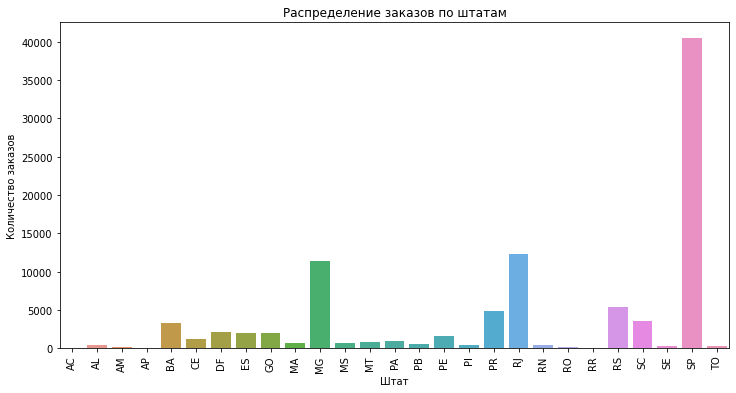

In [47]:
#Для наглядности рассмотрим эти данные на графике
plt.figure(figsize=(12,6))
sns.barplot(data=state_df, x='customer_state', y='order_id')
plt.xticks(rotation=90)  
plt.xlabel("Штат")
plt.ylabel("Количество заказов")
plt.title("Распределение заказов по штатам")

**Выводы**
1. Медианный retention = 0.35%, свидетельствует о низкой возвращаемости клиентов;
2. Среднее время доставки с момента подтвреждения оплаты до момента получения заказа - 11,6 дней, что указывает на долгую доставку;
3. Доля доставок с опозданием - 8,1%, что свидетельствует о наличии проблем в логистике;
4. Отток клиентов (Churn Rate) 96.99% означет, что почти все клиенты уходят, после первого заказа;
5. Средняя стоимость товаров - 21.7$ свидетельствует об отсутствии дороговизны товаров;
6. Доля отмененных заказов (canceled) 0,63% , по причине недоступности товаров (unavailable) 0,61% , означает наличие достаточного ассортимента;   
7. Георграфическое распространение, большая часть заказов приходится на несколько ключевых штатов (SP, RJ, MG,RS, PR), что свидетельствует о слабом присутствии в других штатах.

## Итог
**Исходя из вышеперечисленной информации, Product/Market Fit у продукта отсутствует.**

# Определим 5 основных метрик, на которых продакт может сконцентрироваться, чтобы максимизировать прибыль компании:

## 1. Первая метрика  **Gross Merchandise Value (Валовая стоимость товаров)** 
Общая стоимость товара или услуг, проданных через маркетплейс в период времени в денежном выражении. 

Фильтрацию менять не стал, оставил только доставленные товары, т.к. по ним точно видна реальная прибыль

In [48]:
#Агрегигурем по заказам, для избежания дублей
gmv_per_order = olist_order_items_dataset.groupby('order_id', as_index=False).agg({'price': 'sum'})

#Объединяем с таблицей заказов
orders_gmv = customers_orders_сopy.merge(gmv_per_order, on='order_id', how='left')

In [49]:
orders_gmv.shape

(96478, 19)

In [50]:
orders_gmv.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_period                          period[M]
order_period_day                      period[D]
cohort                                period[M]
cohort_day                            period[D]
period_number_month                     float64
delivery_time                           float64
price                                   float64
dtype: object

In [51]:
orders_gmv.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_period,order_period_day,cohort,cohort_day,period_number_month,delivery_time,price
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,2017-05-16,2017-05,2017-05-16,0.0,8.0,124.99
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01,2018-01-12,2018-01,2018-01-12,0.0,16.0,289.00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05,2018-05-19,2018-05,2018-05-19,0.0,25.0,139.94
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03,2018-03-13,2018-03,2018-03-13,0.0,14.0,149.94
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07,2018-07-29,2018-07,2018-07-29,0.0,11.0,230.00


In [52]:
#Считаем общий GMV 
gmv_total = orders_gmv.price.sum().round()
print(f"Общий GMV составляет - {gmv_total}")

Общий GMV составляет - 13221498.0


In [53]:
#Подготавливаем данные для дальнейшей визуализации, группируем по месяцам
orders_gmv_period = orders_gmv.groupby('order_period', as_index=False).agg(GMV = ('price','sum'))
orders_gmv_period

,order_period,GMV
0,2016-09,134.97
1,2016-10,40325.11
2,2016-12,10.90
3,2017-01,111798.36
4,2017-02,234223.40
5,2017-03,359198.85
6,2017-04,340669.68
7,2017-05,489338.25
8,2017-06,421923.37
9,2017-07,481604.52


Text(0.5, 1.0, 'Распределение GMV по месяцам')

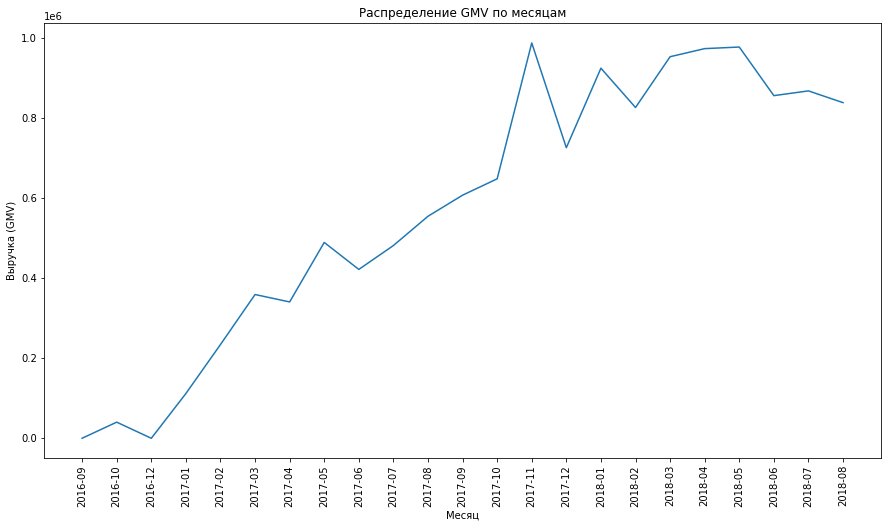

In [54]:
#Визуализация метрики GMV по месяцам
plt.figure(figsize=(15,8))
sns.lineplot(data=orders_gmv_period, x=orders_gmv_period.order_period.astype(str), y='GMV')

plt.xticks(rotation=90)  
plt.xlabel("Месяц")
plt.ylabel("Выручка (GMV)")
plt.title("Распределение GMV по месяцам")


## 2. Вторая метрика  **Monthly Active Users (MAU)** 
Количество уникальных пользователей, совершивших хотя бы одно действие за месяц

Для этого изменяю фильтрацию. Включаю все заказы, кроме:

отмененных (canceled), отмененных из-за отсутствия товара (unavailable)
Эти заказы не должны влиять на активность, т.к. пользователи не получили ценность от сервиса.

In [55]:
#Формирую список с нужными статусами
valid_statuses = ['delivered', 'invoiced', 'shipped', 'processing', 'approved', 'created']
#Фильтрую данные по статусам
customers_orders_valid_statuses = customers_orders.query('order_status in @valid_statuses').copy()


In [56]:
#Выделяем месяц из даты
customers_orders_valid_statuses['month'] = customers_orders_valid_statuses['order_purchase_timestamp'].dt.to_period('M')

In [57]:
customers_orders_valid_statuses.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07


In [58]:
#Подготавливаем данные для дальнейшей визулазации
customers_MAU = customers_orders_valid_statuses.groupby('month', as_index=False).agg(MAU = ('customer_unique_id','nunique'))

In [59]:
customers_MAU.dtypes

month    period[M]
MAU          int64
dtype: object

Text(0.5, 1.0, 'Динамика MAU по месяцам')

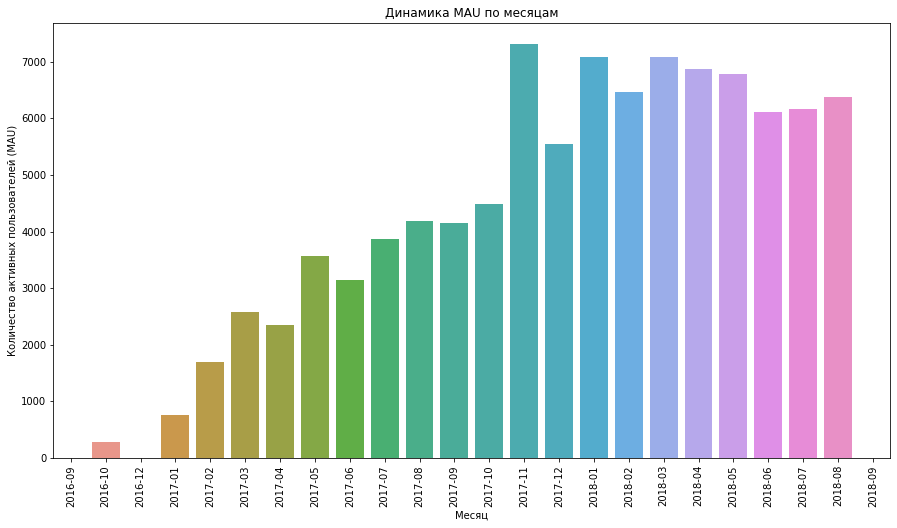

In [60]:
#Делаем визуализацию метрики MAU
plt.figure(figsize = (15,8))
sns.barplot(data=customers_MAU, x="month", y="MAU")
plt.xticks(rotation=90)
plt.xlabel("Месяц")
plt.ylabel("Количество активных пользователей (MAU)")
plt.title("Динамика MAU по месяцам")


## 3. Третья метрика  **Conversion Rate (CR)**

Описание: Эта метрика показывает, какой процент новых пользователей совершает покупку после регистрации. Это может быть рассчитано как отношение количества транзакций к количеству новых пользователей. К примеру высокий CR указывает на то, что маркетплейс успешно привлекает и конвертирует новых пользователей в покупателей. 

## 4. Четвертая метрика  **Частота покупок (Purchase Frequency)** 
Метрика показывает, сколько раз в среднем клиент совершает покупку за определенный период (в нашем случае за месяц). Она помогает понять, насколько активно клиенты возвращаются для повторных покупок, что является важным индикатором их вовлеченности и лояльности к продукту.

In [61]:
#Фильтрацию оставляем, как в предыдущей метрики, только валидные заказы.
#Группируем по месяцаv, считаем общее количество заказов и уникальных клиентов
customers_orders_frequency = customers_orders_valid_statuses.groupby('month', as_index=False).agg(total_orders = ('order_id','count'), unique_customers = ('customer_unique_id', 'nunique'))

In [62]:
#Проверка на наличие дубликатов
customers_orders_valid_statuses[['customer_unique_id', 'order_id']].duplicated().sum()

0

In [63]:
#Cчитаем частоту
customers_orders_frequency['frequency'] = customers_orders_frequency['total_orders']/customers_orders_frequency['unique_customers']

In [64]:
customers_orders_frequency

,month,total_orders,unique_customers,frequency
0,2016-09,2,2,1.000000
1,2016-10,293,290,1.010345
2,2016-12,1,1,1.000000
3,2017-01,787,753,1.045153
4,2017-02,1718,1693,1.014767
5,2017-03,2617,2577,1.015522
6,2017-04,2377,2345,1.013646
7,2017-05,3640,3569,1.019894
8,2017-06,3205,3142,1.020051
9,2017-07,3946,3872,1.019112


<function matplotlib.pyplot.show(*args, **kw)>

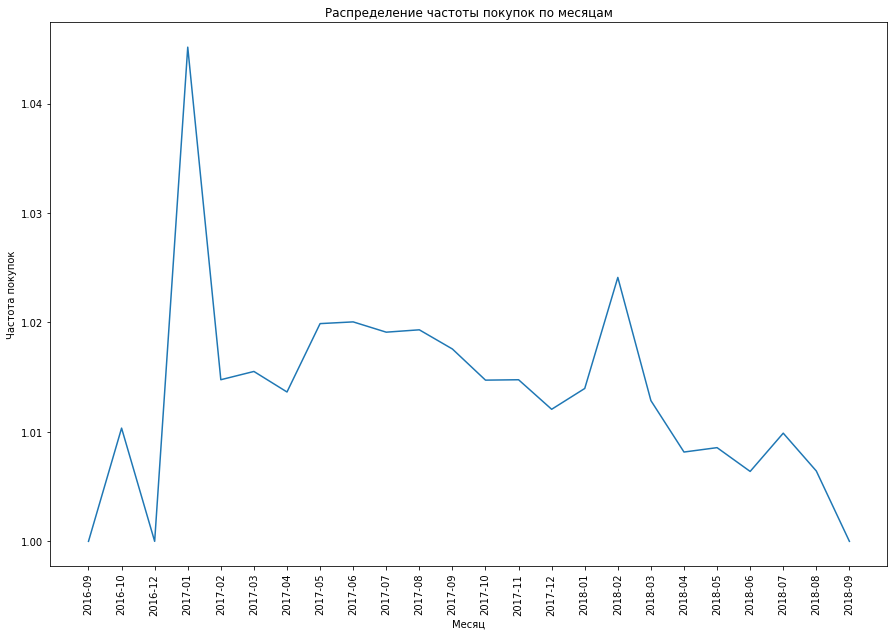

In [65]:
#Строим график
plt.figure(figsize = (15,10))
sns.lineplot(data = customers_orders_frequency, x = customers_orders_frequency.month.astype(str), y = 'frequency')
plt.xticks (rotation = 90)
plt.title('Распределение частоты покупок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Частота покупок')
plt.show

## 5. Пятая метрика  **Средний доход на пользователя (ARPU - Average Revenue Per User)** 
Эта метрика показывает, сколько денег в среднем приносит каждый пользователь за определенный период. Это позволяет оценить финансовую эффективность привлечения и удержания пользователей.

In [66]:
orders_gmv_period

,order_period,GMV
0,2016-09,134.97
1,2016-10,40325.11
2,2016-12,10.90
3,2017-01,111798.36
4,2017-02,234223.40
5,2017-03,359198.85
6,2017-04,340669.68
7,2017-05,489338.25
8,2017-06,421923.37
9,2017-07,481604.52


In [67]:
#Берем данные из расчета GMV(фильтрация только по доставленным товарам) и добавляем в нее MAU .
orders_gmv_period = orders_gmv.groupby('order_period', as_index=False).agg(GMV = ('price','sum'), MAU = ('customer_unique_id','nunique'))

In [68]:
orders_gmv_period['ARPU'] = orders_gmv_period['GMV']/orders_gmv_period['MAU']

In [69]:
orders_gmv_period

,order_period,GMV,MAU,ARPU
0,2016-09,134.97,1,134.970000
1,2016-10,40325.11,262,153.912634
2,2016-12,10.90,1,10.900000
3,2017-01,111798.36,718,155.708022
4,2017-02,234223.40,1630,143.695337
5,2017-03,359198.85,2508,143.221232
6,2017-04,340669.68,2274,149.810765
7,2017-05,489338.25,3479,140.654858
8,2017-06,421923.37,3076,137.166245
9,2017-07,481604.52,3802,126.671362


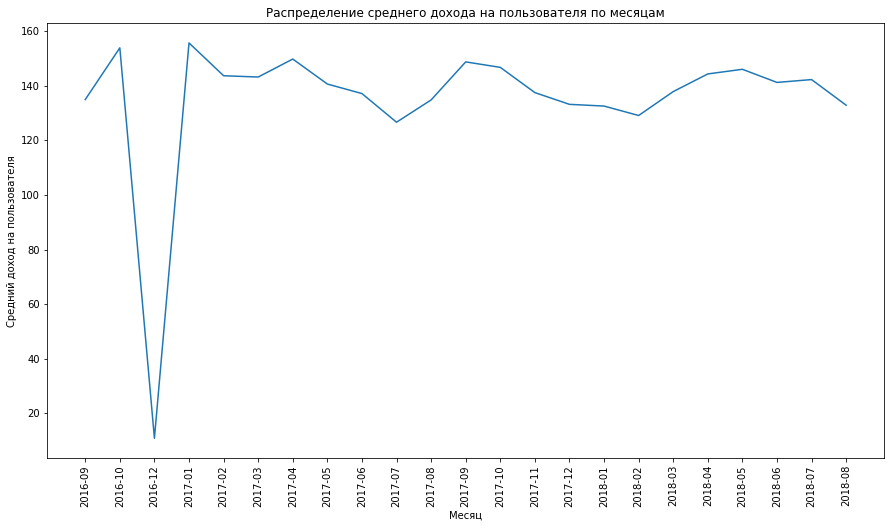

In [70]:
#Делаем визуализацию метрики
plt.figure(figsize = (15,8))
sns.lineplot(data =orders_gmv_period, x = orders_gmv_period.order_period.astype(str), y = 'ARPU' )
plt.xticks(rotation=90)
plt.title('Распределение среднего дохода на пользователя по месяцам')
plt.xlabel('Месяц')
plt.ylabel ('Средний доход на пользователя')
plt.show()

# Выбираем одну из 3 основных гипотез с помощью фреймворка ICE.

Обсудив с продактом когортный анализ и метрики, решили, что нужно изменить продукт. Метрики необходимо повышать. Вместе с командой были сформулированы 3 гипотезы. По каждой гипотезе команда заполнила показатели по Ease, Confidence. Нужно рассчитать показатель — Impact, учитывая шкалу метрики. 

Для расчёта Impact нужно взять данные с июня 2017 года. Считаем, что конверсия в повторный заказ равна величине медианного retention 1-го месяца (см. пункт 1 проекта).

Гипотезы:
1. Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.	
2. Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов. 
3. Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов.

In [71]:
#Делаем фильтрацию по заданному периоду
customers_orders_filtered = customers_orders[customers_orders['order_purchase_timestamp']>= '2017-06-01']
#Проверяю, что остались только нужные
customers_orders_filtered.order_purchase_timestamp.sort_values()

95276   2017-06-01 00:05:38
78889   2017-06-01 00:12:32
47395   2017-06-01 00:13:42
50514   2017-06-01 00:39:20
37784   2017-06-01 00:41:00
                ...        
75985   2018-09-29 09:13:03
75902   2018-10-01 15:30:09
68312   2018-10-03 18:55:29
69139   2018-10-16 20:16:02
85415   2018-10-17 17:30:18
Name: order_purchase_timestamp, Length: 87746, dtype: datetime64[ns]

In [72]:
#Для понимание смотрим общее количество заказов за нужный период
customers_orders_filtered.order_id.nunique()

87746

In [73]:
customers_orders_filtered

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05


Cчитаем **количество заказов**, которые возможно будет реанимировать при внеднернии каждой гипотезы

In [74]:
#1.Количество отмененных заказов
#Фильтруем по canceled. Не учитываю unavailable, т.к. это связано больше с наличием ассортимента, а не багом в системе
customers_orders_canceled = customers_orders_filtered.query('order_status == "canceled"')
impact_value_1 = customers_orders_canceled.shape[0]
print(f'Итого: {impact_value_1} заказов отменяют')

Итого: 499 заказов отменяют


Так как указано, что мы избавимся от всех отмен, конверсию считаем 100%

In [75]:
#2.Количество заказов с опозданием 
#Убираем нулевые значения в дате доставки 
customers_orders_filtered_drop = customers_orders_filtered.dropna(subset =['order_delivered_customer_date'])
customers_orders_filtered_drop.isna().sum() #проверяем

customer_id                      0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_id                         0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     1
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

In [76]:
delivery_late = (customers_orders_filtered_drop['order_delivered_customer_date']
                        <customers_orders_filtered_drop['order_estimated_delivery_date']).value_counts()

In [77]:
#Считаем количество заказов, которые приходят с задержкой
late = delivery_late[False]
print(f'Итого: {late} заказов приходят с задержкой')

Итого: 7296 заказов приходят с задержкой


In [78]:
#Рассчитываем показатель impact для 2й гипотезы
impact_value_2 = late *median_retention_1 #количество заказов, с учетом конверсии по заданию
impact_value_2

25.536

In [79]:
#3.Считаем все единичные заказы за нужный период
#Фильтруем данные по валидным статусам, группируем по клиентам и считаем количество заказов

filtered_valid=customers_orders_filtered.query('order_status in @valid_statuses')\
                                        .groupby('customer_unique_id').agg(order_count=('order_id', 'nunique'))\
                                        .query('order_count==1')

In [80]:
#проверяем, что остались только единичные заказы
filtered_valid.sort_values('order_count', ascending = False) 

,order_count
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,1
aa4da86cd687b4f4b040122da582369b,1
aa541fa381d763426a5a445ad2dd0d70,1
aa53cf1e7f6ecf44d9ecd0fbc1efb059,1
aa53470c30cfd5c372dd45a57203e529,1
...,...
5513ea33a42a77b2dcbc2691ad56557a,1
55133cf96f44c834ac51d0e3b678c7a8,1
5511558799e00a6828ae95c9bd9aec98,1


In [81]:
filtered_valid.shape[0] #количество заказов, которые потенциально могут конвертироваться в повторные после внедрения гипотезы

81785

In [82]:
#Рассчитываем показатель impact для 3й гипотезы
impact_value_3 = filtered_valid.shape[0]*median_retention_1 #количество заказов, с учетом конверсии
print(impact_value_3)

286.2475


**Для дальшейго перевода метрики в `Impact` используем следующую шкалу:**

| Impact            | 1     | 2      | 3       | 4       | 5        | 6         | 7         | 8          | 9           | 10           |
|-------------------|-------|--------|---------|---------|----------|-----------|-----------|------------|-------------|--------------|
| Значение метрики  | 0–50  | 51–150 | 151–350 | 351–750 | 751–1550 | 1551–3150 | 3151–6350 | 6351–12750 | 12751–25550 | 25551–51150  |


## Считаем ICE для каждой гипотезы

In [83]:
#Гипотеза 1 
Confidence_1 = 8
Ease_1 = 6 
Impact_1 = 4 #по школе значение метрики 499
ICE_1 = Confidence_1*Ease_1*Impact_1
print(f'ICE Гипотезы 1 составяет - {ICE_1}')

ICE Гипотезы 1 составяет - 192


In [84]:
#Гипотеза 2 
Confidence_2 = 10
Ease_2 = 4 
Impact_2 = 1 #по школе значение метрики 25,5
ICE_2 = Confidence_2*Ease_2*Impact_2
print(f'ICE Гипотезы 2 составяет - {ICE_2}')

ICE Гипотезы 2 составяет - 40


In [85]:
#Гипотеза 3 
Confidence_3 = 5
Ease_3 = 9 
Impact_3 = 3 #по школе значение метрики 286,2
ICE_3 = Confidence_3*Ease_3*Impact_3
print(f'ICE Гипотезы 3 составяет - {ICE_3}')

ICE Гипотезы 3 составяет - 135


## Вывод:
Исходя из проведенных расчетов ICE, делаем вывод, что внедрение гипотезы 1 окажет наибольшее влияние.

Гипотеза 1: «Если исправим баг в системе процессинга заказов, то клиентам не придется сталкиваться с проблемой отмены заказов, вследствие чего количество доставленных заказов увеличится».

Считаем, что устранение бага позволит восстановить 499 отмененных заказов, тем самым увеличив общее число доставленных товаров. Это также положительно скажется на пользовательском опыте, так как клиенты не будут сталкиваться с проблемами отмены.

Таким образом, гипотеза 1 должна принести наибольший эффект среди всех предложенных.

# Сформулируем метрики, на которые гипотеза должна повлиять.

Было предложено провести A/B-тестирование гипотезы для проверки её эффективности.

Продакт попросил:

1. Сформулировать метрики, на которые должна повлиять выбранная  гипотеза.
2. Сформулировать хотя бы по одной метрике в категории: целевые, прокси, guardrail.

### **Целевые метрики**
Целевые метрики напрямую отражают успех гипотезы и измеряют основную цель.
1. Количество отмененных заказов: 
Гипотеза предполагает устранение всех отмен, эта метрика должна значительно уменьшиться.
2. Количество доставленных заказов:
Ключевая метрика, т.к. напрямую отражает успех гипотезы. Ожидаемое изменение: рост метрики после исправления бага.

### **Прокси метрики**
Прокси-метрики помогают оценить промежуточные изменения, которые могут быть связаны с целевыми. 
1. Время обработки заказа:
Если баг в системе процессинга заказов исправлен, время обработки заказа (среднее время от момента оформления заказа до его подтверждения) должно сократиться.

2. Процент успешных транзакций:
Если баг влияет на процессинг заказов, то исправление должно повысить долю успешных транзакций.

### **Guardrail метрики**
Guardrail-метрики помогают убедиться, что изменения не оказывают негативного влияния на другие аспекты бизнеса.
1. Количество обращений в тех.поддержку.Если баг будет исправлен,обращений в поддержку по вопросу отмены заказов станет меньше.
2. Конверсия: Процент пользователей, которые сделали заказ после добавления товаров в корзину. Если баг исправлен корректно и мы ничего не сломали, данная метрика не должна уменьшиться.


# Отчет по результатам проведённой работы с компанией.



## 1. Формализация проблемы продукта
В ходе исследования мы выявили, что одной из ключевых проблем является отмена, ранее оформленных заказов и низкая возвращаемость клиентов. Это может происходить из-за ошибок в процессинге, запаздывания доставки или неудобного оформления оплаты. Наша цель заключалась в том, чтобы выбрать гипотезу, которая наиболее эффективно решает эту проблему и улучшает ключевые метрики маркетплейса

## 2. Описание выводов по Retention
Мы исследовали датасет и определили, что для расчета Retention следует учитывать только доставленные заказы, так как отмененные и недоставленные заказы не отражают реальную вовлеченность пользователей.

Основные результаты анализа:

- **Месячный retention** был рассчитан с помощью когортного анализа по когортам пользователей, сделавших первый заказ в определенный месяц.
- **Медианный retention на 1-й месяц составил 0.0035**, что указывает на низкий уровень возвращаемости пользователей.
- **Когорта с самым высоким retention на 3-й месяц – январь 2017 года**. Это может свидетельствовать о том, что в этот период проводились успешные маркетинговые акции или были другие факторы, способствующие удержанию клиентов.

**Вывод:** retention показывает, что большая часть пользователей не возвращается после первой покупки. Это подтверждает необходимость улучшения клиентского опыта и поиска способов повышения вовлеченности


## 3. Анализ PMF — Product Market Fit

Мы провели анализ для определения наличия Product-Market Fit (PMF) у продукта. Для этого были рассчитаны ключевые показатели, отражающие вовлеченность клиентов и эффективность бизнес-модели.

Основные результаты анализа:

- **Медианный retention** составил **0,35%**, что свидетельствует о крайне низкой возвращаемости клиентов. Большая часть пользователей не совершает повторных покупок.
- **Среднее время доставки** с момента подтверждения оплаты до момента получения заказа составило **11,6 дней**, что говорит о наличии проблем в логистике и может негативно сказываться на удовлетворенности клиентов.
- **Доля доставок с опозданием — 8,1%**, что свидетельствует о высоком уровне задержек, потенциально влияющих на доверие пользователей.
- **Отток клиентов (Churn Rate)** составляет **96,99%**, что означает, что почти все клиенты уходят после первого заказа. Это указывает на слабую вовлеченность и отсутствие сформированной лояльной базы пользователей.
- **Средняя стоимость товаров — 21,7%** свидетельствует об отсутствии дороговизны товаров.
- **Доля отмененных заказов (canceled) — 0,63%, а по причине недоступности товаров (unavailable) — 0,61%**, что говорит о возможных проблемах в процессинге заказов и о достаточном наличии ассортимента.
- **Географическое распределение** заказов показывает, что большая часть заказов поступает из нескольких ключевых штатов **(SP, RJ, MG, RS, PR)**, что свидетельствует о слабом присутствии в других регионах.

**Вывод:** анализ показывает, что **Product-Market Fit (PMF) у продукта отсутствует**, так как клиенты не демонстрируют высокой вовлеченности, а основные метрики указывают на проблемы с доставкой, отменой заказов и географическим охватом.



## 4. Определяем ключевые метрики, чтобы максимизировать прибыль компании.

Мы провели анализ и определили 5 ключевых метрик, на которые продакт-менеджер может сфокусироваться, чтобы максимизировать прибыль компании. Эти метрики отражают рост объема продаж, аудиторию продукта, заинтересованность клиентов и вовлеченность пользователей.

Выбранные метрики:
- **GMV (Gross Merchandise Value)** – общая стоимость товара или услуг, проданных через маркетплейс в период времени в денежном выражении. Эта метрика отражает рост выручки компании.
- **MAU (Monthly Active Users)** – количество уникальных пользователей за месяц. Показывает объем аудитории, которой продукт приносит ценность.
- **Conversion Rate (CR)** – метрика показывает, какой процент новых пользователей совершает покупку после регистрации. Это может быть рассчитано как отношение количества транзакций к количеству новых пользователей. К примеру высокий CR указывает на то, что маркетплейс успешно привлекает и конвертирует новых пользователей в покупателей
- **Частота покупок (Purchase Frequency)** - метрика показывает, сколько раз в среднем клиент совершает покупку за определенный период (в нашем случае за месяц). Она помогает понять, насколько активно клиенты возвращаются для повторных покупок, что является важным индикатором их вовлеченности и лояльности к продукту.
- **Средний доход на пользователя (ARPU - Average Revenue Per User)** - метрика показывает, сколько денег в среднем приносит каждый пользователь за определенный период. Это позволяет оценить финансовую эффективность привлечения и удержания пользователей.

Для более наглядного анализа были построены визуализации для GMV, MAU, Purchase Frequency и ARPU с месячной гранулярностью.

**Вывод:**
Данные метрики помогут оценить динамику роста продаж, анализировать вовлеченность клиентов и принимать стратегические решения для увеличения прибыли маркетплейса. Визуализация метрик позволила наглядно увидеть их поведение и выявить ключевые тенденции.

## 5. ICE-анализ гипотез

Мы рассмотрели три гипотезы, которые могли бы улучшить ключевые метрики маркетплейса, и оценили их по ICE-фреймворку (Impact, Confidence, Ease).

Рассмотренные гипотезы:
1. Исправление ошибки в процессинге заказов – устранение проблемы отмены заказов из-за багов в системе.
2. Ускорение времени отгрузки – уменьшение задержек в логистике для увеличения количества повторных заказов.
3. Создание нового способа оплаты – упрощение оформления заказов для повышения конверсии пользователей в повторные покупки.

Результаты расчета ICE:
- Гипотеза 1 (исправление ошибки в процессинге) получила ICE = 192, что делает ее наиболее приоритетной для реализации.
- Гипотеза 2 (ускорение времени отгрузки) имеет ICE = 40, что делает ее менее эффективной.
- Гипотеза 3 (новый способ оплаты) получила ICE = 135, что также является значительным, но уступает первой гипотезе.

**Вывод**:на основе ICE-анализа мы пришли к выводу, что исправление ошибки в процессинге заказов имеет наивысший потенциал влияния на бизнес-метрики и должно быть приоритетным для реализации. Оно может привести к  снижению отмен, увеличению количества успешно доставленных заказов и росту выручки.


## 6. Формулировка метрик
В рамках задачи мы сформулировали ключевые метрики, на которые должна повлиять выбранная гипотеза. Метрики были разделены на три категории: целевые, прокси и guardrail.

### **Целевые метрики**
Целевые метрики напрямую отражают успех гипотезы и измеряют основную цель.

**1. Количество отмененных заказов:** 
Гипотеза предполагает устранение всех отмен, эта метрика должна значительно уменьшиться.

**2. Количество доставленных заказов:**
Ключевая метрика, т.к. напрямую отражает успех гипотезы. Ожидаемое изменение: рост метрики после исправления бага.

### **Прокси метрики**
Прокси-метрики помогают оценить промежуточные изменения, которые могут быть связаны с целевыми.

**1. Время обработки заказа:**
Если баг в системе процессинга заказов исправлен, время обработки заказа (среднее время от момента оформления заказа до его подтверждения) должно сократиться.

**2. Процент успешных транзакций:**
Если баг влияет на процессинг заказов, то исправление должно повысить долю успешных транзакций.

### **Guardrail метрики**
Guardrail-метрики помогают убедиться, что изменения не оказывают негативного влияния на другие аспекты бизнеса.

**1. Количество обращений в тех.поддержку:**
Если баг будет исправлен,обращений в поддержку по вопросу отмены заказов станет меньше.

**2. Конверсия:**
Процент пользователей, которые сделали заказ после добавления товаров в корзину. Если баг исправлен корректно и мы ничего не сломали, данная метрика не должна уменьшиться.

**Вывод:** мы определили ключевые метрики для оценки эффективности гипотезы и последующего мониторинга. С помощью целевых метрик мы оцениваем основной эффект от гипотезы, прокси метрики позволяют косвенно измерить её влияние, а guardrail метрики обеспечивают контроль за возможными негативными последствиями.

## 7. Общие выводы по итогу исследования
В ходе проведенного исследования было выявлено, что основная проблема, влияющая на показатели маркетплейса, заключается в высоком уровне отмененных заказов и низкой возвращаемости клиентов. Анализ показал, что эти проблемы напрямую связаны с качеством процессинга заказов, а также с неудобствами в процессе доставки. Это снижает лояльность пользователей и их удержание.

Исправление ошибок в процессинге заказов, а также улучшение логистики и удобства оформления заказа имеют наибольшее влияние на снижение числа отмен и увеличение числа успешно выполненных заказов. Это, в свою очередь, должно привести к росту выручки компании.

Также важно отметить, что наиболее эффективной гипотезой для реализации стала гипотеза о исправлении ошибок процессинга, так как она получила наивысшую оценку по методу ICE. Реализация данной гипотезы будет иметь долгосрочное влияние на улучшение показателей маркетплейса и удовлетворенности пользователей.

Помимо этого, для решения проблемы важно также работать над достижением Product-Market Fit (PMF), что является ключевым этапом для роста компании и повышения качества пользовательского опыта.

Таким образом, основное внимание следует уделить исправлению ошибок в процессинге заказов и улучшению взаимодействия с клиентами на всех этапах, что обеспечит улучшение ключевых метрик и устойчивый рост бизнеса



## 8. Рекомендации по продукту
- Работать над внедрением Product-Market Fit (PMF), поскольку его достижение критически важно для обеспечения долгосрочного роста и удовлетворенности клиентов.

- Реализовать исправление ошибки в процессинге заказов. Это поможет уменьшить количество отмен, повысить процент доставленных заказов, улучшить клиентский опыт и увеличить выручку.

- Провести A/B-тестирование на ограниченной выборке пользователей. Для более точной оценки влияния изменений на ключевые метрики, такие как конверсия и количество отмен, необходимо провести A/B-тестирование на небольшом сегменте пользователей. Это позволит получить статистически значимые результаты.

- Оценить влияние изменения на ключевые метрики и принять решение о масштабировании. По результатам A/B-тестирования, если изменения окажутся статистически значимыми и покажут положительные результаты, можно принять решение о полном масштабе внедрения улучшений на всех пользователей маркетплейса. В случае, если результаты окажутся незначимыми или негативными, можно будет пересмотреть гипотезу и улучшить процесс.